In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("../data/01_raw/Colombia.csv")
df.head()

/var/folders/sm/6wwssnjd59v95bx9k441v1900000gn/T/ipykernel_48870/1495181280.py:1: DtypeWarning: Columns (27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,50,51,52,53,55,56,57,63,65,66,118,120,122,127) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/01_raw/Colombia.csv")


,Unnamed: 0,offer_id,created_date_shp,updated_date_shp,agreement_id_shp,organization_id,sales_id_shp,offer_type_shp,agreement_row_id_shp,gsfa_customer_id,...,competitor_oppo,industry,order_in_oppo,offers_in_oppo,finality,final_outcome,final_discount_shp,revenue_bin,discount_oms,discount_delta
0,0,CO_O_118566890719,2020-08-13 14:22:47,2024-10-30 22:06:47,NaN,DHL CO,CRINCONV,Standard GPI Offer,NaN,COSCSV_0522019365634,...,NaN,IND:CSMR,NaN,NaN,interim,NaN,NaN,low,35.997299,-35.997299
1,1,CO_O_118920199284,2020-09-15 11:39:46,2024-10-30 21:10:03,CO_O_118920199284,DHL CO,GLHERRER,Standard GPI Offer,1-1W0AAQ-366,COSISL_07300114147852,...,NaN,IND:CSMR,NaN,NaN,interim,NaN,NaN,low,28.999503,-8.999245
2,2,CO_O_118920199284,2020-09-15 11:39:46,2024-10-30 21:10:03,CO_O_118920199284,DHL CO,GLHERRER,Standard GPI Offer,1-1W0AAQ-366,COSISL_07300114147852,...,NaN,IND:CSMR,NaN,NaN,interim,NaN,NaN,low,44.002825,21.324002
3,3,CO_O_118920199284,2020-09-15 11:39:46,2024-10-30 21:10:03,CO_O_118920199284,DHL CO,GLHERRER,Standard GPI Offer,1-1W0AAQ-366,COSISL_07300114147852,...,NaN,IND:CSMR,NaN,NaN,interim,NaN,NaN,low,50.000000,24.035608
4,4,CO_O_118962044578,2020-09-18 03:32:44,2024-10-30 21:10:03,CO_O_118962044578,DHL CO,DRACOSTA,Standard GPI Offer,1-241PAS-355,COCUS08070152,...,NaN,IND:CSMR,NaN,NaN,interim,NaN,NaN,NaN,45.999827,4.000523


In [6]:
df["final_outcome"].value_counts()

Accepted       9216
In Progress    3313
Rejected       1389
Name: final_outcome, dtype: int64

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Dict


def plot_feature_analysis(
    X_test, observed, predicted, benchmark=None, exposure=None
) -> Dict[str, plt.Figure]:
    """
    Iterates over all feature columns in X_test to generate Matplotlib figures.
    Returns a dictionary of figures, which can be saved using Kedro's MatplotlibWriter.

    Parameters:
    - X_test (DataFrame): Feature dataset (numerical and categorical).
    - observed (array-like): Observed average values.
    - predicted (array-like): Predicted average values.
    - benchmark (array-like, optional): Benchmark average values. If None, it's not plotted.
    - exposure (array-like, optional): Exposure values (used as weights in aggregation).

    Returns:
    - Dict[str, plt.Figure]: A dictionary where keys are feature names and values are Matplotlib figures.
    """
    if exposure is None:
        exposure = (
            np.ones(len(X_test)) * 1000
        )  # Assume uniform exposure if not provided

    figures = {}  # Dictionary to store Matplotlib figures

    for feature in X_test.columns:
        temp_df = X_test[[feature]].copy()
        temp_df["Observed"] = observed
        temp_df["Predicted"] = predicted
        temp_df["Exposure"] = exposure

        if benchmark is not None:
            temp_df["Benchmark"] = benchmark

        # Handle numerical vs categorical features
        if pd.api.types.is_numeric_dtype(temp_df[feature]):
            temp_df["Feature_Binned"] = pd.qcut(
                temp_df[feature], q=10, labels=[f"Q{i + 1}" for i in range(10)]
            )
        else:
            temp_df["Feature_Binned"] = temp_df[feature]  # Keep categorical as-is

        # Aggregate with weighted means
        agg_dict = {
            "Observed": lambda x: np.average(
                x, weights=temp_df.loc[x.index, "Exposure"]
            ),
            "Predicted": lambda x: np.average(
                x, weights=temp_df.loc[x.index, "Exposure"]
            ),
            "Exposure": "sum",
        }

        if benchmark is not None:
            agg_dict["Benchmark"] = lambda x: np.average(
                x, weights=temp_df.loc[x.index, "Exposure"]
            )

        df_grouped = temp_df.groupby("Feature_Binned").agg(agg_dict).reset_index()

        # Compute weighted difference
        df_grouped["Weighted_Diff"] = df_grouped["Predicted"] - df_grouped["Observed"]

        # --- Seaborn Plotting ---
        fig, axes = plt.subplots(
            2, 1, figsize=(12, 6), gridspec_kw={"height_ratios": [3, 1]}, sharex=True
        )

        # Top Panel: Line Plot
        sns.lineplot(
            x="Feature_Binned",
            y="Observed",
            data=df_grouped,
            marker="s",
            color="red",
            label="Observed avg vs exposure",
            ax=axes[0],
        )
        sns.lineplot(
            x="Feature_Binned",
            y="Predicted",
            data=df_grouped,
            marker="s",
            color="teal",
            label="Predicted avg vs exposure",
            ax=axes[0],
        )

        if benchmark is not None:
            sns.lineplot(
                x="Feature_Binned",
                y="Benchmark",
                data=df_grouped,
                marker="s",
                color="purple",
                label="Benchmark avg vs exposure",
                ax=axes[0],
            )

        # Bar Plot for Weighted Difference
        sns.barplot(
            x="Feature_Binned",
            y="Weighted_Diff",
            data=df_grouped,
            color="orange",
            alpha=0.5,
            ax=axes[0],
        )

        # Labels & Grid
        axes[0].set_ylabel("Mean weighted by exposure")
        axes[0].legend()
        axes[0].grid(axis="y", linestyle="--", alpha=0.7)

        # Bottom Panel: Bar Plot for Exposure
        sns.barplot(
            x="Feature_Binned",
            y="Exposure",
            data=df_grouped,
            color="orange",
            edgecolor="gray",
            ax=axes[1],
        )

        # Labels & Grid
        axes[1].set_ylabel("Sum of Exposure")
        axes[1].set_xlabel(f"Feature: {feature} (Numerical Quantiles + Categorical)")
        axes[1].grid(axis="y", linestyle="--", alpha=0.7)
        axes[1].set_xticks(
            range(len(df_grouped["Feature_Binned"]))
        )  # Set fixed tick positions
        axes[1].set_xticklabels(
            df_grouped["Feature_Binned"], rotation=45
        )  # Apply labels

        # Store the figure instead of displaying it
        plt.tight_layout()
        figures[feature] = fig  # Store figure in dictionary

    return figures  # Return the dictionary of figures for Kedro's MatplotlibWriter

{'num_feature': <Figure size 1200x600 with 2 Axes>,
 'cat_feature': <Figure size 1200x600 with 2 Axes>}

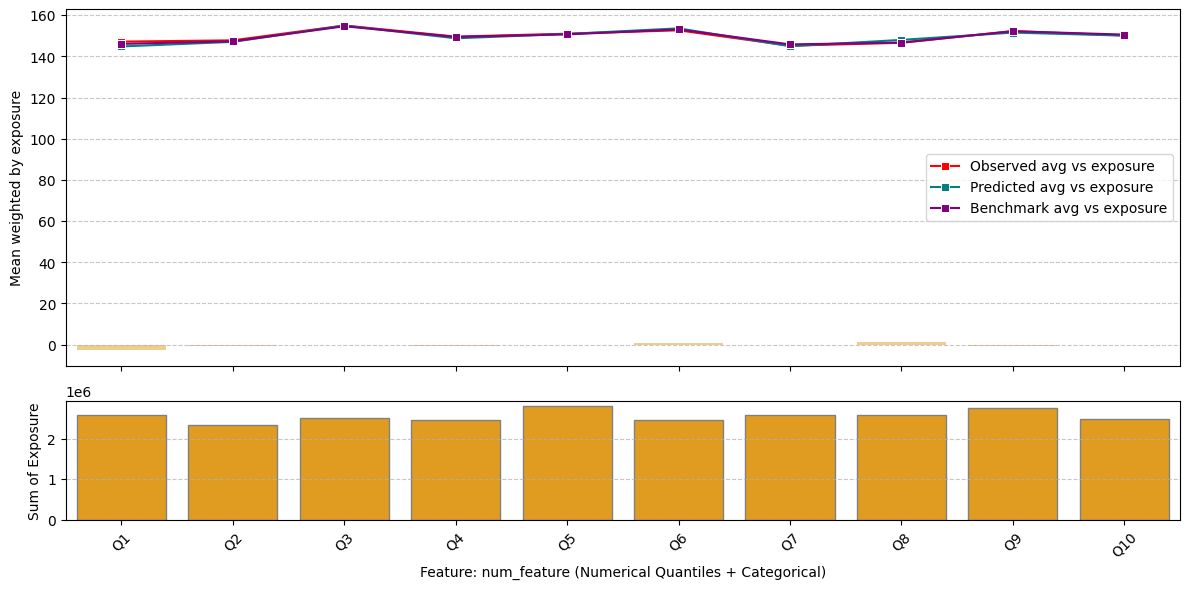

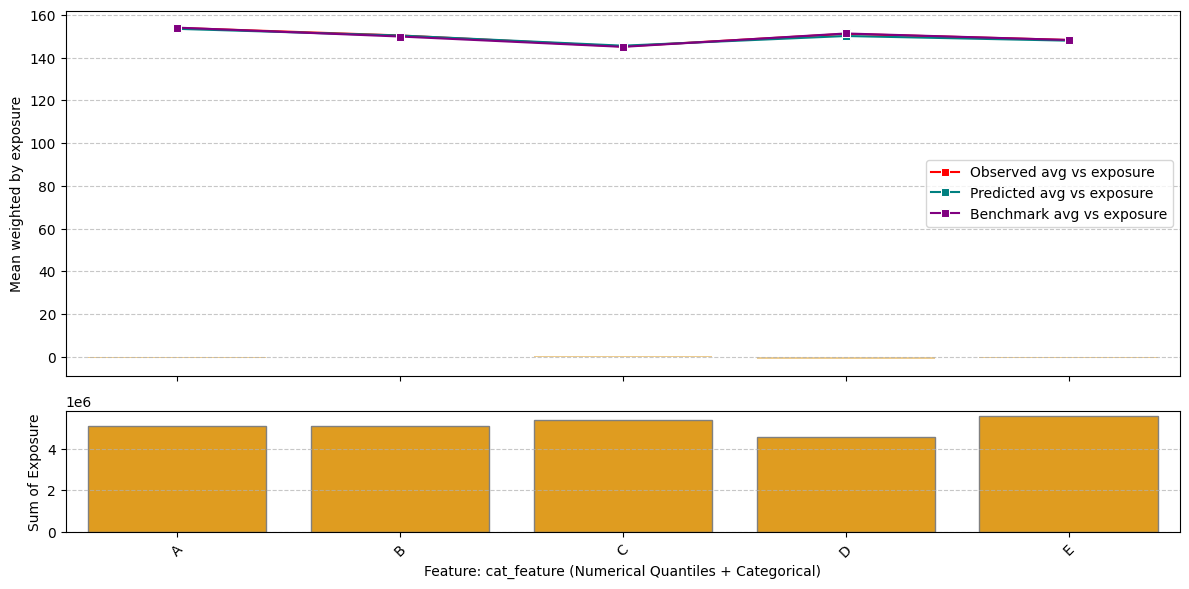

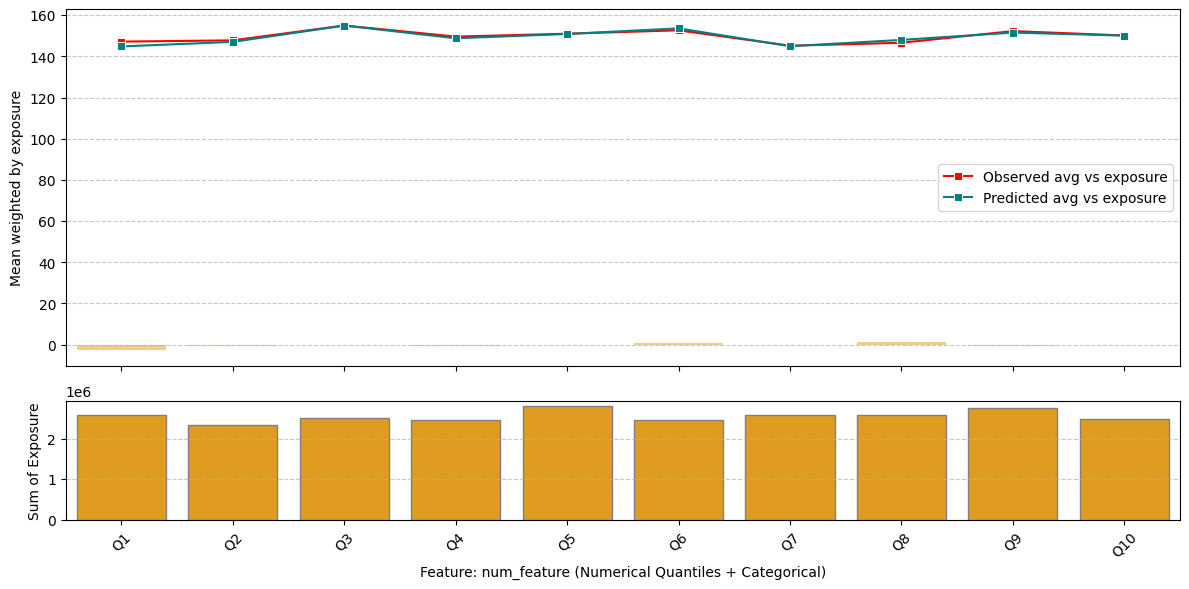

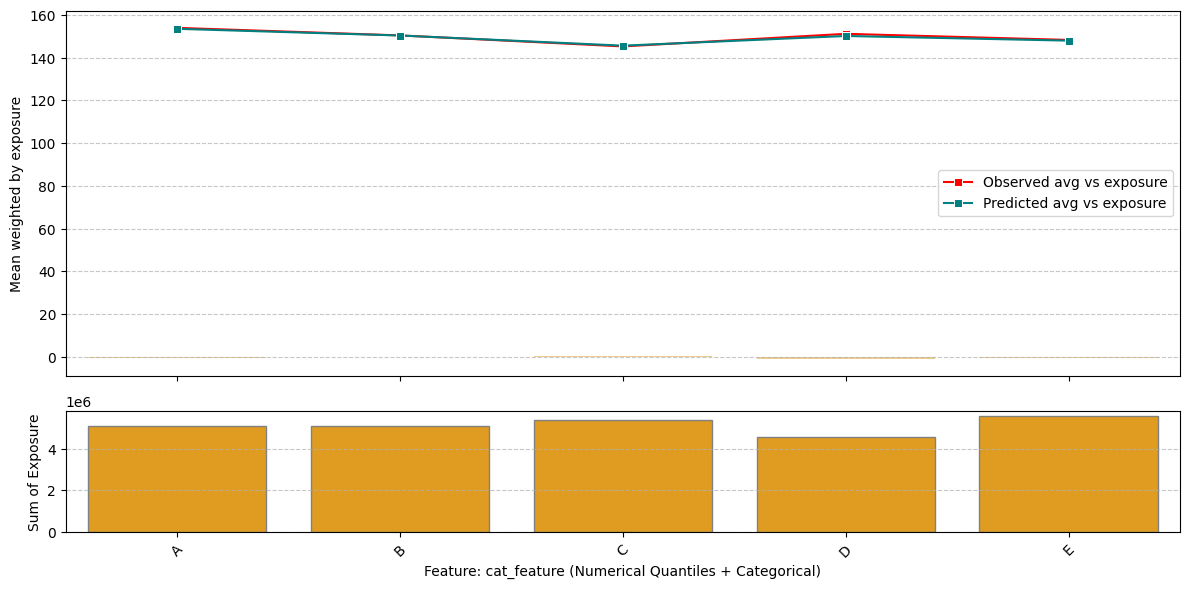

In [10]:
# Sample dataset
np.random.seed(42)
X_test = pd.DataFrame(
    {
        "num_feature": np.random.uniform(0, 100, 500),  # Continuous numerical feature
        "cat_feature": np.random.choice(
            ["A", "B", "C", "D", "E"], 500
        ),  # Categorical feature
    }
)

observed = np.random.uniform(100, 200, 500)
predicted = observed + np.random.uniform(-10, 10, 500)
benchmark = observed + np.random.uniform(-5, 5, 500)  # Optional
exposure = np.random.randint(5000, 100000, 500)  # Optional

# Run function with benchmark
plot_feature_analysis(X_test, observed, predicted, benchmark, exposure)

# Run function without benchmark
plot_feature_analysis(X_test, observed, predicted, exposure=exposure)

In [15]:
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston

# Load data
data = load_boston()
X, y = data.data, data.target

# Train model
model = RandomForestRegressor()
model.fit(X, y)

# SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# SHAP Summary Plot
shap.summary_plot(shap_values, X, feature_names=data.feature_names)

# SHAP Dependence Plot for a single feature
shap.dependence_plot("RM", shap_values, X, feature_names=data.feature_names)

# Partial Dependence Plot
features = [0, 5]  # Example features
shap.plots.plot_partial_dependence(model, X, features, feature_names=data.feature_names)
plt.show()

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/Users/jonas_cristens/projects/postal-pricing/.venv/lib/python3.10/site-packages/sklearn/inspection/__init__.py)

[LightGBM] [Info] Number of positive: 359, number of negative: 341
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 475
[LightGBM] [Info] Number of data points in the train set: 700, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512857 -> initscore=0.051440
[LightGBM] [Info] Start training from score 0.051440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

ValueError: train and valid dataset categorical_feature do not match.

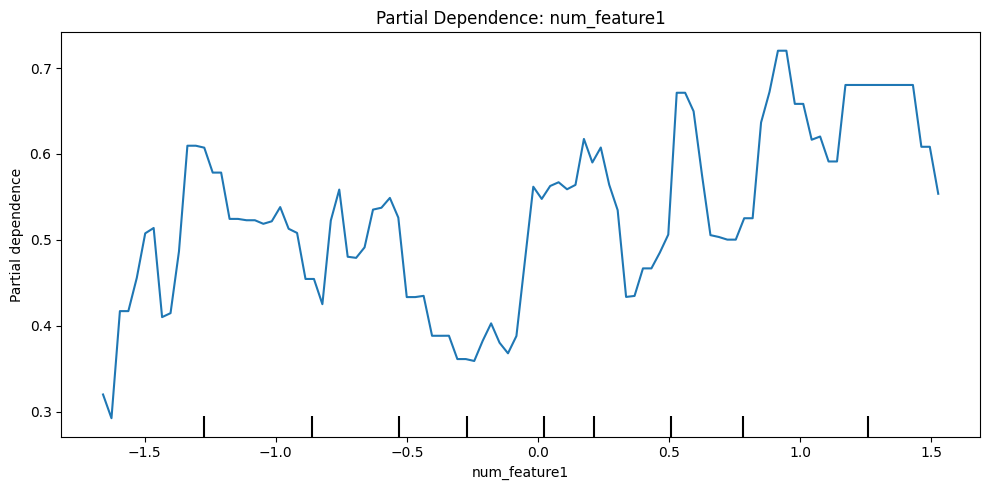

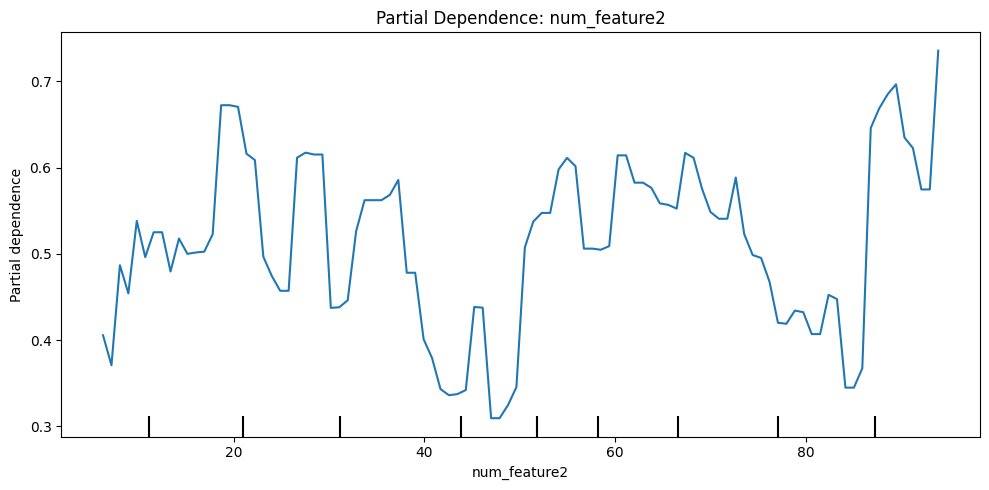

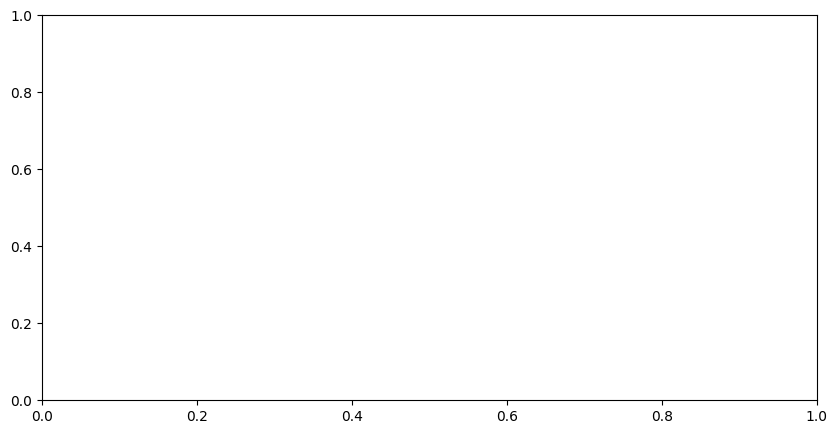

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# 1️⃣ Generate synthetic dataset with categorical & numerical features
np.random.seed(42)
num_rows = 1000

df = pd.DataFrame(
    {
        "num_feature1": np.random.randn(num_rows),
        "num_feature2": np.random.rand(num_rows) * 100,
        "cat_feature1": np.random.choice(["A", "B", "C"], size=num_rows),
        "cat_feature2": np.random.choice(["X", "Y"], size=num_rows),
        "target": np.random.choice([0, 1], size=num_rows),  # Binary classification
    }
)

# 2️⃣ Convert categorical columns to 'category' dtype for LightGBM
cat_features = ["cat_feature1", "cat_feature2"]
df[cat_features] = df[cat_features].astype("category")

# 3️⃣ Split dataset into train & test sets
X = df.drop(columns=["target"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# 4️⃣ Define preprocessing steps for numerical features only
num_features = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = Pipeline(
    [
        ("scaler", StandardScaler())  # Standardizing only numerical features
    ]
)

# 5️⃣ Train LightGBM model (using native categorical handling)
model = lgb.LGBMClassifier(
    n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42
)
model.fit(X_train, y_train, categorical_feature=cat_features)


# 6️⃣ Function to plot PDPs using Sklearn
def plot_sklearn_pdp(model, X_test, feature_names):
    """
    Generate Sklearn Partial Dependence Plots (PDPs).
    """
    plots_dict = {}

    for feature in feature_names:
        fig, ax = plt.subplots(figsize=(10, 5))

        PartialDependenceDisplay.from_estimator(
            model, X_test, features=[feature], ax=ax, categorical_features=cat_features
        )

        ax.set_title(f"Partial Dependence: {feature}")
        plt.tight_layout()
        plots_dict[f"{feature}_pdp_plot.png"] = fig

    return plots_dict


# 7️⃣ Generate PDP plots for all features
pdp_plots = plot_sklearn_pdp(model, X_test, X_test.columns.tolist())

# 🔟 Show a specific PDP plot
pdp_plots["num_feature1_pdp_plot.png"].show()